## avoided crossing data to extract maximum dissipator frequency $\omega_\mathrm{max}/2\pi$ and couping strength $g$

In [70]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# read data from Labber directory
labber_dir = 'G:\\Shared drives\\LFL\\Labber\\Data\\2023\\'
date_dir = '05\\Data_0502\\'
filename = 'diss08_09A_6024_fluxSweep.hdf5'

f = h5py.File(labber_dir + date_dir + filename,'r')


In [16]:
vna = 'Agilent Network Analyzer E5071B'
s21 = f['Traces'][f'{vna} - S21'][()]
s21_complex = s21[:,0,:]+1j*s21[:,1,:]
numsteps = f['Traces'][f'{vna} - S21_N'][0][()]
frange = f['Traces'][f'{vna} - S21_t0dt'][0][()]
freqs = np.linspace(frange[0],frange[0]+frange[1]*(numsteps-1),numsteps)
currents = np.array(f['Data']['Data'])[:,0,0]

In [17]:
start = 0
stop = len(currents)-1
fcut = freqs
s21cut = s21_complex[:,start:stop]
ccut = currents[start:stop]

Text(0, 0.5, 'Frequency (GHz)')

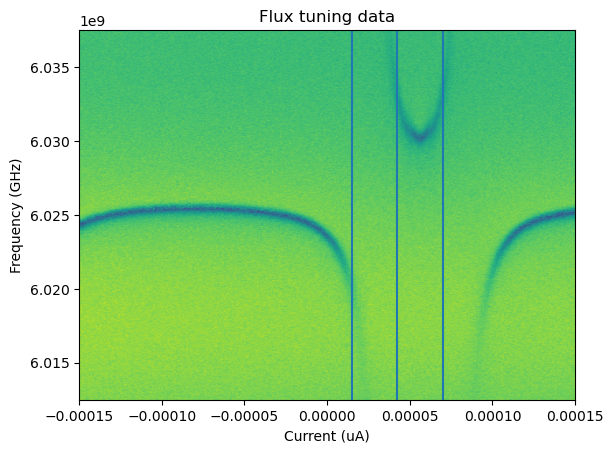

In [28]:
plt.imshow(abs(s21_complex), aspect='auto',origin='lower',extent=(currents[0], currents[-1], freqs[0], freqs[-1]))
plt.axvline(ccut[165])
plt.axvline(ccut[192])
plt.axvline(ccut[220])
plt.title('Flux tuning data')
plt.xlabel('Current (uA)')
plt.ylabel('Frequency (GHz)') 

In [55]:
s21cut.shape

(1601, 300)

In [58]:
s21_minfit = np.zeros(len(ccut))
for i in range(len(ccut)):
    print(i)
    if i<165:
        minpos = np.argmin(abs(s21cut[:1050,i]))
        s21_minfit[i] = freqs[minpos]
    elif (i>=192 and i<=220):
        minpos = np.argmin(abs(s21cut[:,i]))
        s21_minfit[i] = freqs[minpos]
    else:
        s21_minfit[i] = 'nan'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
s21_minfit.shape

(300,)

In [51]:
freqs

array([6.01250000e+09, 6.01251562e+09, 6.01253125e+09, ...,
       6.03746875e+09, 6.03748438e+09, 6.03750000e+09])

In [52]:
np.argmin(abs(freqs-6.03e9))

1120

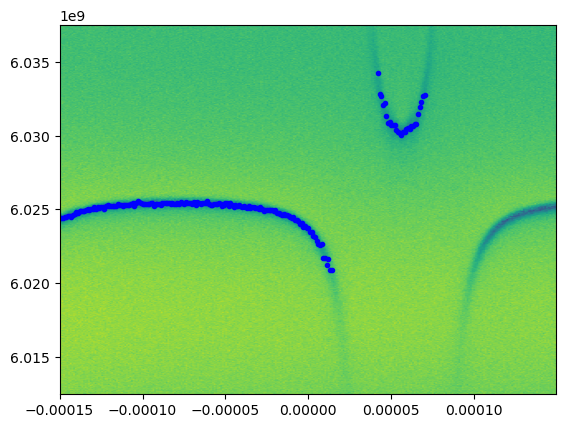

In [59]:

plt.show
plt.figure()
plt.imshow(abs(s21cut), aspect='auto',origin='lower',extent=(ccut[0], ccut[-1], freqs[0], freqs[-1]))
plt.scatter(ccut,s21_minfit,marker='.',c='blue')


In [68]:
# fit each trace for frequency
# grab trace from s21 matrix
index = 0
idata = s21[:,0,index]
qdata = s21[:.1,index]
plt.plot


# extract current periodicity and translate current to flux

1601

### model

(194,)


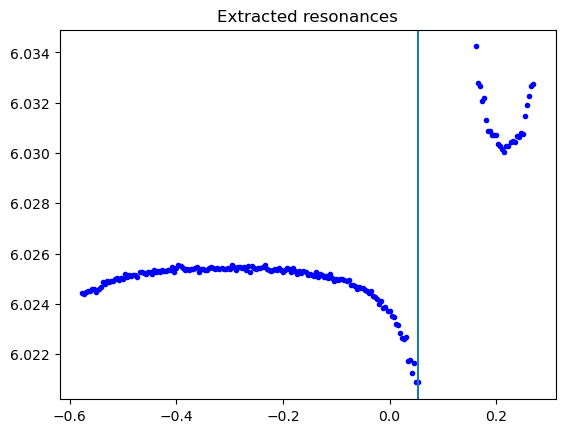

In [96]:
### model
x = ccut*1e6/260
y = s21_minfit/1e9
mask = np.isnan(y)
fitx = x[~mask]
fity=y[~mask]
plt.scatter(fitx,fity,marker='.',c='blue')
print(np.shape(fitx))
plt.axvline(fitx[164])
plt.title('Extracted resonances')

def avoided_crossing(x, wq_max, wc, g,phi_offset,d):
    y = np.zeros(len(x))
    for i in range(len(x)):
        flux_dep = np.emath.power(abs(np.cos(np.pi*x[i]-phi_offset)),2) + d**2*np.emath.power(abs(np.sin(np.pi*x[i]-phi_offset)),2)
        wq = wq_max*np.emath.power(flux_dep, 1/4)
        if i<=164: #where the cropped lower curve ends
            y[i] = 1/2*(-np.emath.sqrt(4*g**2+(wc-wq)**2) + np.emath.sqrt(4*g**2+(wc+wq)**2))
        else:
            y[i] = 1/2*(np.emath.sqrt(4*g**2+(wc-wq)**2) + np.emath.sqrt(4*g**2+(wc+wq)**2))
    return y

In [97]:
popt, pcov = curve_fit(avoided_crossing,fitx,fity,p0=[11,6.025,.1,-75/260,0.01])
#bounds=([0,0,0.05,-np.inf, -0.3],[15,7,0.5,np.inf,0.3]))
#get r^2
residuals = fity-avoided_crossing(fitx,*popt)
ss_res = np.sum(residuals**2) #residual sum of squares
ss_tot = np.sum((fity - np.mean(fity))**2) #total sum of squares
r_squared = 1 - (ss_res/ss_tot)
                                                                                                 
print("Wq_max = "+str(popt[0])+" GHz")
print("Wc = "+str(popt[1])+" GHz")
print("g = "+str(popt[2])+" GHz")
print("phi_offset = "+str(popt[3]))
print("d (junction asymmetry) = "+str(popt[4]))
print("R^2 of fit = ",r_squared)

def avoided_crossing_lower(x, wq_max, wc, g,phi_offset,d):
    flux_dep = np.emath.power(abs(np.cos(np.pi*x-phi_offset)),2) + d**2*np.emath.power(abs(np.sin(np.pi*x-phi_offset)),2)
    wq = wq_max*np.emath.power(flux_dep, 1/4)
    return 1/2*(-np.emath.sqrt(4*g**2+(wc-wq)**2) + np.emath.sqrt(4*g**2+(wc+wq)**2))

def avoided_crossing_upper(x, wq_max, wc, g, phi_offset,d):
    flux_dep = np.emath.power(abs(np.cos(np.pi*x-phi_offset)),2) + d**2*np.emath.power(abs(np.sin(np.pi*x-phi_offset)),2)
    wq = wq_max*np.emath.power(flux_dep, 1/4)
    return 1/2*(np.emath.sqrt(4*g**2+(wc-wq)**2) + np.emath.sqrt(4*g**2+(wc+wq)**2))

Wq_max = 10.552186272644008 GHz
Wc = 6.026952189328056 GHz
g = 0.09434429394750576 GHz
phi_offset = -0.8954139381094105
d (junction asymmetry) = 0.02182446898347419
R^2 of fit =  0.9907901727134598


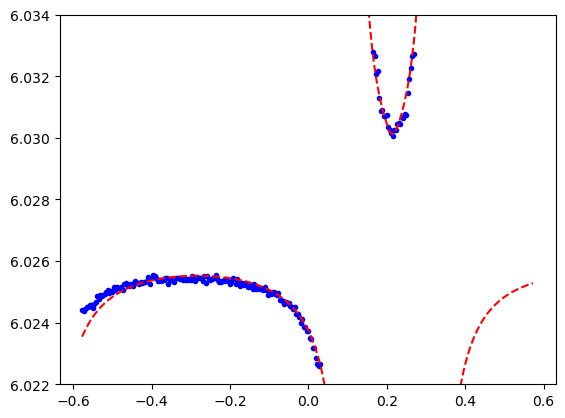

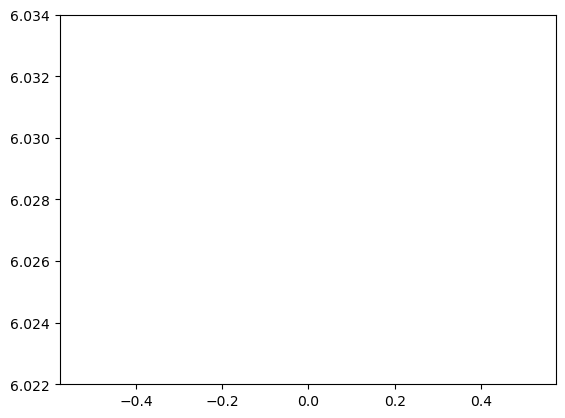

In [99]:
plt.scatter(fitx,fity,marker='.',c='blue')
plt.plot(x,avoided_crossing_lower(x,*popt),'r--')
plt.plot(x,avoided_crossing_upper(x,*popt),'r--')
plt.ylim([6.022, 6.034])


In [110]:
avoided_crossing_upper(-75/260, *popt)-avoided_crossing_upper(5/260, *popt)

2.5323514517921932

In [134]:
avoided_crossing_upper(-15/260, *popt)

9.176979684671576

# estimate ffl drive amplitude

In [115]:
f = h5py.File('G:\\Shared drives\\CavityCooling\\data\\diss09_6024\\20230511\\calibration\\fflCalibration_DA=34dB_navg=4000_1.h5')

In [116]:
f.keys()

<KeysViewHDF5 ['rrSpecFFL_16:11:05', 'rrSpecFFL_16:21:31', 'rrSpecFFL_16:28:25', 'rrSpecFFL_16:44:51', 'rrSpecFFL_16:50:26', 'rrSpecFFL_16:50:39', 'rrSpecFFL_16:59:34', 'rrSpecFFL_17:48:51']>

In [117]:
f['rrSpecFFL_17:48:51'].keys()

<KeysViewHDF5 ['ffl flux = 1000 uA', 'ffl flux = 1020 uA', 'ffl flux = 1040 uA', 'ffl flux = 1060 uA', 'ffl flux = 1080 uA', 'ffl flux = 1100 uA', 'ffl flux = 900 uA', 'ffl flux = 920 uA', 'ffl flux = 940 uA', 'ffl flux = 960 uA', 'ffl flux = 980 uA']>

In [119]:
f['rrSpecFFL_16:59:34'].keys()

<KeysViewHDF5 ['ffl flux = 600 uA', 'ffl flux = 620 uA', 'ffl flux = 640 uA', 'ffl flux = 660 uA', 'ffl flux = 680 uA', 'ffl flux = 700 uA', 'ffl flux = 720 uA', 'ffl flux = 740 uA', 'ffl flux = 760 uA', 'ffl flux = 780 uA', 'ffl flux = 800 uA']>

In [120]:
f['rrSpecFFL_16:50:39'].keys()

<KeysViewHDF5 ['ffl flux = 280 uA', 'ffl flux = 300 uA', 'ffl flux = 320 uA', 'ffl flux = 340 uA', 'ffl flux = 360 uA', 'ffl flux = 380 uA', 'ffl flux = 400 uA', 'ffl flux = 420 uA', 'ffl flux = 440 uA', 'ffl flux = 460 uA', 'ffl flux = 480 uA', 'ffl flux = 500 uA']>

In [121]:
f['rrSpecFFL_16:50:26'].keys()

<KeysViewHDF5 []>

In [122]:
f['rrSpecFFL_16:44:51'].keys()

<KeysViewHDF5 ['ffl flux = 113 uA', 'ffl flux = 131 uA', 'ffl flux = 149 uA', 'ffl flux = 167 uA', 'ffl flux = 185 uA', 'ffl flux = 95 uA']>

In [123]:
f['rrSpecFFL_16:28:25'].keys()

<KeysViewHDF5 ['ffl flux = 23 uA', 'ffl flux = 41 uA', 'ffl flux = 5 uA', 'ffl flux = 59 uA', 'ffl flux = 77 uA', 'ffl flux = 95 uA']>

In [124]:
f['rrSpecFFL_16:21:31'].keys()

<KeysViewHDF5 ['flux = -11 uA', 'flux = -19 uA', 'flux = -27 uA', 'flux = -3 uA', 'flux = -35 uA', 'flux = -43 uA', 'flux = -51 uA', 'flux = -59 uA', 'flux = -67 uA', 'flux = -75 uA', 'flux = 5 uA']>

In [127]:
f['rrSpecFFL_16:21:31']['flux = -11 uA'].keys()

<KeysViewHDF5 ['I', 'Q', 'freqs']>

In [125]:
f['rrSpecFFL_16:11:05'].keys()

<KeysViewHDF5 []>

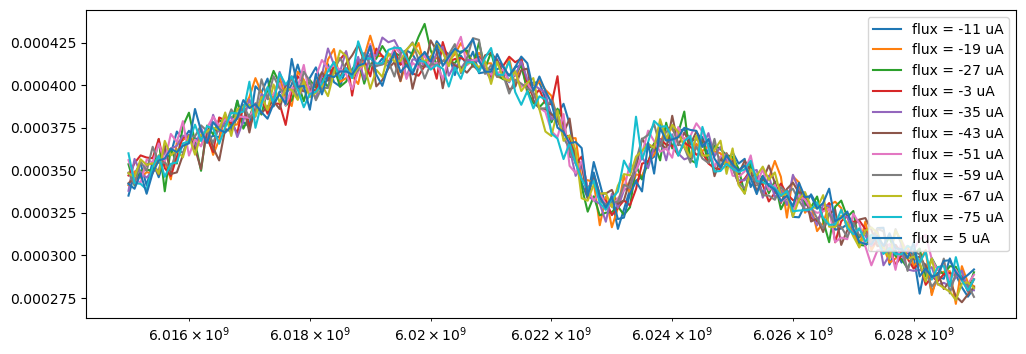

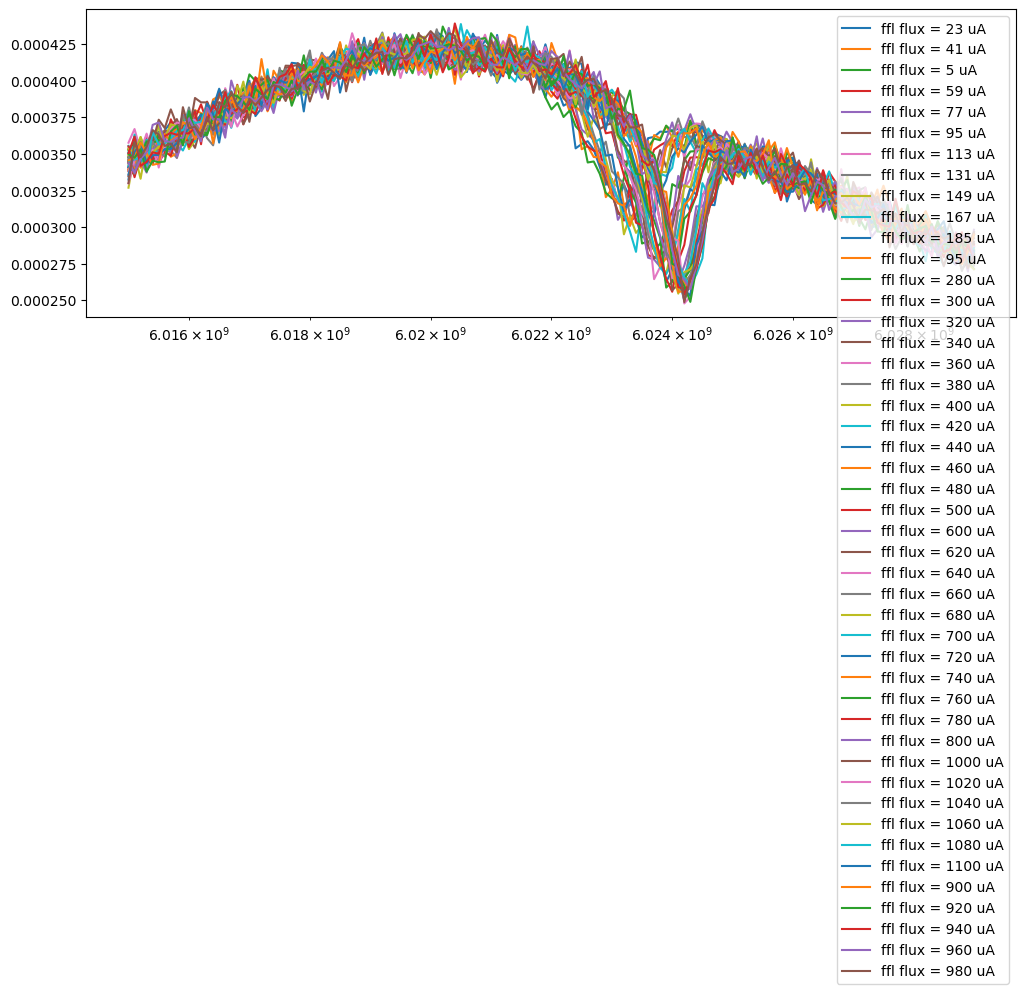

In [132]:
# group keys in ffl and coil
data_coil = {}
data_ffl = {}
fig1, ax1 = plt.subplots(1,1, figsize=(12,4))
fig2, ax2 = plt.subplots(1,1, figsize=(12,4))
for data_key in f.keys():
    for k in f[data_key].keys():
        freqs = np.array(f[data_key][k]['freqs'])
        I = np.array(f[data_key][k]['I'])
        Q = np.array(f[data_key][k]['Q'])
        if 'ffl' in k:
            ax2.plot(freqs, np.abs(I+1j*Q), label=k)
            data_ffl[k] = np.stack((I,Q), axis=-1)
        else:
            ax1.plot(freqs, np.abs(I+1j*Q), label=k)
            data_coil[k] = np.stack((I,Q), axis=-1)
            
ax1.legend()
ax2.legend()
ax1.set_xscale('log')
ax2.set_xscale('log')

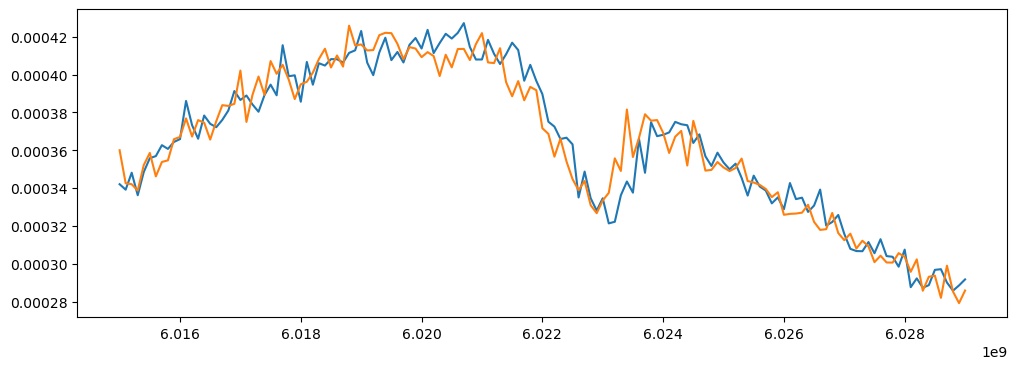

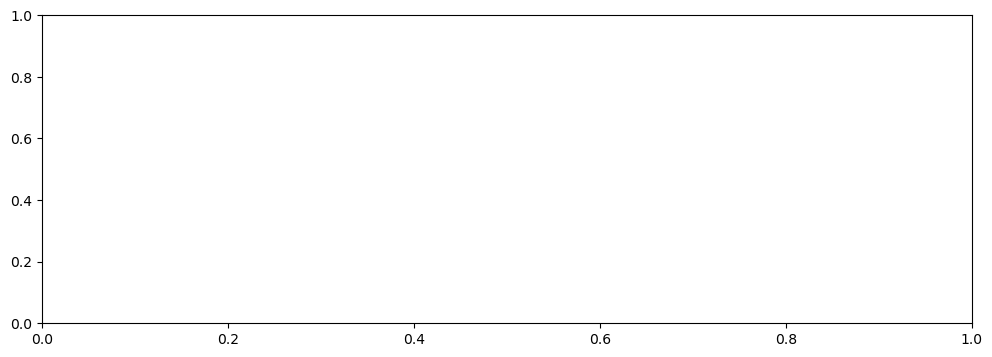

In [133]:
fig1, ax1 = plt.subplots(1,1, figsize=(12,4))
fig2, ax2 = plt.subplots(1,1, figsize=(12,4))
coil_keys  = ['flux = 5 uA', 'flux = -75 uA']
for key in coil_keys:
    ax1.plot(freqs, np.abs(data_coil[key][:,0]+1j*data_coil[key][:,1]),label=key)
